# JAXson5

In [1]:
import os
os.environ['XLA_FLAGS']="--xla_gpu_cuda_data_dir=/usr/local/cuda-10.1"
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.5'
           
import matplotlib.pylab as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.random import sample_without_replacement
from sklearn.utils import shuffle,resample

from sklearn.linear_model import Ridge


import jax
from jax import random, numpy as jnp

from flax import optim
from flax.core import freeze, unfreeze

from modax.models import DeepmodMultiExpKS
from modax.training import create_update_state
from modax.losses import loss_fn_pinn_multi2, mse_test
from modax.sparsity_estimators import get_mask_single
from modax.sparsity_scheduler import mask_scheduler
from modax.logger import Logger
from modax.convergence import Convergence

from time import time

%load_ext autoreload
%autoreload 2

In [2]:
name_feats = [r'$1$', r'$u_x$', '$u_{xx}$', '$u_{xxx}$','$u_{xxxx}$', '$u$', '$u u_{x}$', '$u u_{xx}$', '$u u_{xxx}$','$u u_{xxxx}$', '$u^2$', '$u^2 u_{x}$', '$u^2 u_{xx}$', '$u^2 u_{xxx}$','$u^2 u_{xxxx}$']
len(name_feats)

15

# General params

In [3]:
key = random.PRNGKey(42)

In [4]:



noise_level = 0.01
#number_of_samples = 25000


nn_shared_features = []
nn_specific_features = [65,65,65,65,1]


deltaSP = 1e-5
deltaC = 1e-2

learning_rate = 2e-4
max_epochs = 250001

write_tensorboard = True
path = 'nKS01'



# Data with some noise

In [5]:
#u     = np.array(np.load('../data/files/KS_uN.npy'),dtype=np.float32)
u     = np.array(np.load('../data/files/KS_u.npy'),dtype=np.float32)
u     = u + noise_level*np.std(u)*np.random.randn(u.shape[0],u.shape[1])

x     = np.load('../data/files/KS_x.npy')
t     = np.load('../data/files/KS_t.npy')


In [6]:
u.shape

(1024, 251)

In [7]:
x.shape

(1024,)

In [8]:
t.shape

(251,)

In [9]:
x_grid,  t_grid = jnp.meshgrid(x,  t, indexing="ij")


In [10]:
x_grid.shape

(1024, 251)

In [11]:
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("white")


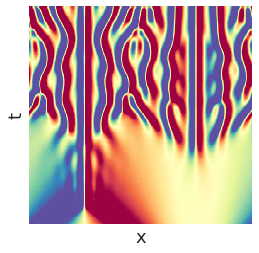

In [12]:
fig,ax = plt.subplots(1,1, figsize=(4,4))

u1_noisy = u

bx = sns.heatmap(u1_noisy.T,ax=ax,vmin=-1,vmax=1,cmap='Spectral',cbar=False)
bx.invert_yaxis()    
bx.set_xticks([])
bx.set_yticks([])

ax.set_xlabel('x')
ax.set_ylabel('t');

In [13]:
idx_g = np.logical_and(t_grid>45,t_grid<55)
mask = np.zeros_like(idx_g)
mask[idx_g] = 1


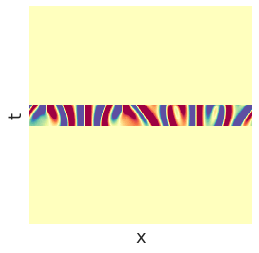

In [14]:
fig,ax = plt.subplots(1,1, figsize=(4,4))

bx = sns.heatmap((u1_noisy*mask).T,ax=ax,vmin=-1,vmax=1,cmap='Spectral',cbar=False)
bx.invert_yaxis()    
bx.set_xticks([])
bx.set_yticks([])

ax.set_xlabel('x')
ax.set_ylabel('t');

In [15]:
(u1_noisy[mask]).shape

(25600,)

## subsampling and normalizing

In [16]:
idx = resample(np.arange(u1_noisy[mask].shape[0]),replace=False,random_state=0) #n_samples=number_of_samples


u1_noisy_shuffled = (u1_noisy[mask])[idx]
xs = ((x_grid[mask])[idx]).reshape(-1,1)
ts = ((t_grid[mask])[idx]).reshape(-1,1)


In [17]:

scale_from_outputs = []
u_d = []

# scaling and subsampling
u_sampled = u1_noisy_shuffled.reshape(-1,1)
u_max = u_sampled.max()
scale_from_outputs.append(u_max)
u_d.append(u_sampled/u_max)

    

In [18]:
X_data = jnp.concatenate([ts/t.max(),xs/x.max()],axis=1)
y_data = jnp.concatenate(u_d,axis=0)

In [19]:
print(X_data.shape)
print(y_data.shape)

(25600, 2)
(25600, 1)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

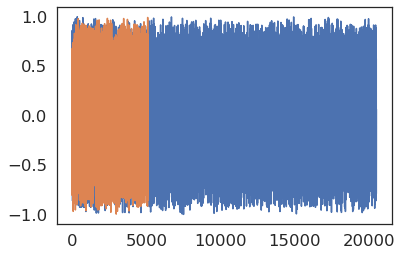

In [21]:
plt.plot(y_train[:,0])
plt.plot(y_test[:,0])

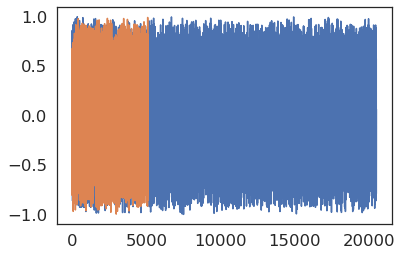

In [22]:
plt.plot(y_train[:,1])
plt.plot(y_test[:,1])

# Model initialization and parameters

In [23]:
nn_specific_features

[65, 65, 65, 65, 1]

In [24]:
# Instantiating model and optimizers
model = DeepmodMultiExpKS(nn_shared_features, nn_specific_features, 1)

In [25]:
#model = DeepmodKS(nn_specific_features)
optimizer = optim.Adam(learning_rate=learning_rate, beta1=0.99, beta2=0.995)
logger = Logger(path)
converged = Convergence(delta=deltaC)

In [26]:
sparsity_scheduler = mask_scheduler(delta=deltaSP)

In [27]:
# initializing
variables = model.init(key, X_train)
state, params = variables.pop('params')
y, updated_state = model.apply(variables, X_train, mutable=['coeffs_mask'])
optimizer = optimizer.create(params)
# compiling train step
update = create_update_state(loss_fn_pinn_multi2, model=model, x=X_train, y=y_train)
_ = update(optimizer, state)  # triggering compilation

In [28]:
# Group lasso warm start initialization
n_exp, n_terms = state['coeffs_mask']['maskC'].shape[0],state['coeffs_mask']['maskC'].shape[1]
coef_ini = [np.zeros([n_terms,n_exp]), np.zeros([n_terms,n_exp])]

# Training 

In [29]:
GT = [2,4,7]

In [ ]:
t_start = time()
counter = 0

for epoch in jnp.arange(max_epochs):

    # updating the model
    (optimizer, state), metrics, dt, theta, coeffs, coeffs_mask = update(optimizer, state)
    if epoch % 500 == 0:
        print(f"Loss step {epoch}: {metrics['mse']}", end='\x1b[1K\r')
    
    if epoch % 25 == 0:   
        # computing losses on test set, masks are set individually
        loss_test, loss_test_exp_wise = mse_test(model, optimizer.target, state, X_test, y_test)
        loss_test_metric = {'loss_test':loss_test_exp_wise}
        
        ############ Logging the IRC ################################################
    
        metrics = {**metrics, **loss_test_metric}

        
            
        thetaNP = np.array(theta,dtype=np.float32).squeeze()
        dtNP = np.array(dt,dtype=np.float32).squeeze()

        # IRC
        # normalizing
        normed_theta = thetaNP/np.linalg.norm(thetaNP,axis=0,keepdims=True)
        normed_dt = dtNP/np.linalg.norm(dtNP,axis=0,keepdims=True)
        x1 = normed_theta[:,GT]
        x2 = normed_theta[:,np.setdiff1d(np.arange(0,normed_theta.shape[1]),np.array(GT))]

        # original design
        metric_IRC = np.abs(np.linalg.inv(x1.T @ x1) @ x1.T @ x2).max()
        lhs_IRC = {'IRC':np.array(metric_IRC)}
        metrics = {**metrics, **lhs_IRC}

        # with adaptive weights
        weights = (np.abs(Ridge(alpha=1e-10,fit_intercept=False).fit(normed_theta,normed_dt).coef_).ravel())**2
        normed_theta_w = normed_theta * weights[np.newaxis, :]
        x1 = normed_theta_w[:,GT]
        x2 = normed_theta_w[:,np.setdiff1d(np.arange(0,normed_theta.shape[1]),np.array(GT))]

        metric_IRC_AW = np.abs(np.linalg.inv(x1.T @ x1) @ x1.T @ x2).max()
        lhs_IRC_AW = {'IRC_Adaptive':np.array(metric_IRC_AW)}        
        metrics = {**metrics, **lhs_IRC_AW}
        
        # condition number
        cond_num = np.linalg.cond(normed_theta_w)
        c_num = {'cond_num_adaptive':np.array(cond_num)} 
        metrics = {**metrics, **c_num}
        

        # Once sparsity has been triggered
        if counter == 1:
            [tau,piT,pSE,alphas, minLambdaSS, active_set,region] = extras
            
            # Probability of being selected
            pSEmax = np.array(pSE).max(axis=0)
            prob = {'prob_selec':pSEmax}   
            metrics = {**metrics, **prob}

            # Trust
            Point_of_View = np.where(active_set)[0].tolist()
            x1 = normed_theta_w[:,Point_of_View]
            x2 = normed_theta_w[:,np.setdiff1d(np.arange(0,normed_theta.shape[1]),np.array(Point_of_View))]

            metric_PoV = np.abs(np.linalg.inv(x1.T @ x1) @ x1.T @ x2).max()
            lhs_PoV = {'PoV':np.array(metric_PoV)}        
            metrics = {**metrics, **lhs_PoV}
        
        logger.write(metrics, epoch)


        #############################################################################
            
            
            
            
        # optimizer best is based on group
        update_sparsity, optimizer = sparsity_scheduler(loss_test, epoch, optimizer)
        if update_sparsity:   
            ############################################################################################
            if counter == 0:
                np.save(path +'/theta_IN',theta)
                np.save(path +'/dt_IN',dt)
                counter = 1
                print('sparsity at ', epoch)

            # that component mask needs to be updated & new mask not yet computed
            new_mask,extras = get_mask_single(theta[0],dt[0],randomized=False)   
            new_mask = new_mask.reshape(1,new_mask.shape[0],new_mask.shape[1])
            ############################################################################################

            # update the masks, the state
            mask = new_mask
            state = freeze({'coeffs_mask': {'maskC': jnp.array(mask)}})


        if converged(epoch, coeffs):
            print(f'Converged at epoch {epoch}')

            np.save(path +'/theta_FIN',theta)
            np.save(path +'/dt_FIN',dt)

            break

logger.close()
t_end = time()
print(t_end - t_start)

############################################################################################
############################################################################################                    

sparsity at  20900.004140650387853384K


/home/georges/anaconda3/envs/jaxSon/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [45]:
metrics['mse']

DeviceArray(0.00119075, dtype=float32)

In [46]:
epoch

250000

In [47]:
print(t_end - t_start)

33312.89329266548


In [48]:
new_params = optimizer.target
new_variables = freeze({'params': new_params.unfreeze(), **state.unfreeze()})

In [49]:
coeffs = model.apply(new_variables,X_train,mutable=['coeffs_mask'])[0][3]

xi = coeffs[:,:,0].T

In [50]:
scale_on_inputs = np.array([1,x.max(),x.max()**2,x.max()**3,x.max()**4,x.max()**5,
                            1,x.max(),x.max()**2,x.max()**3,x.max()**4,x.max()**5,
                            1,x.max(),x.max()**2,x.max()**3,x.max()**4,x.max()**5,
                           1,x.max(),x.max()**2,x.max()**3,x.max()**4,x.max()**5,
                            1,x.max(),x.max()**2,x.max()**3,x.max()**4,x.max()**5,
                            1,x.max(),x.max()**2,x.max()**3,x.max()**4,x.max()**5]).reshape(-1,1)
coeffsS = xi*scale_on_inputs/t.max()
    
    
scaling_term_wise = []
scaling_all = []
for i in range(xi.shape[1]):
    
    scaling_term_wise.append([1,1/scale_from_outputs[i],   1/scale_from_outputs[i],   1/scale_from_outputs[i],    1/scale_from_outputs[i],   1/scale_from_outputs[i], 
                              1,1/scale_from_outputs[i]**2,1/scale_from_outputs[i]**2,1/scale_from_outputs[i]**2, 1/scale_from_outputs[i]**2,1/scale_from_outputs[i]**2,
                              1,1/scale_from_outputs[i]**3,1/scale_from_outputs[i]**3,1/scale_from_outputs[i]**3, 1/scale_from_outputs[i]**3,1/scale_from_outputs[i]**3,
                              1,1/scale_from_outputs[i]**4,1/scale_from_outputs[i]**4,1/scale_from_outputs[i]**4, 1/scale_from_outputs[i]**4,1/scale_from_outputs[i]**4,
                              1,1/scale_from_outputs[i]**5,1/scale_from_outputs[i]**5,1/scale_from_outputs[i]**5, 1/scale_from_outputs[i]**5,1/scale_from_outputs[i]**5,
                              1,1/scale_from_outputs[i]**6,1/scale_from_outputs[i]**6,1/scale_from_outputs[i]**6, 1/scale_from_outputs[i]**6,1/scale_from_outputs[i]**6])
    
    scaling_all.append([scale_from_outputs[i],scale_from_outputs[i],scale_from_outputs[i],scale_from_outputs[i],
                       scale_from_outputs[i],scale_from_outputs[i],scale_from_outputs[i],scale_from_outputs[i],
                       scale_from_outputs[i],scale_from_outputs[i],scale_from_outputs[i],scale_from_outputs[i],
                       scale_from_outputs[i],scale_from_outputs[i],scale_from_outputs[i],scale_from_outputs[i],scale_from_outputs[i],scale_from_outputs[i],scale_from_outputs[i],
                       scale_from_outputs[i],scale_from_outputs[i],scale_from_outputs[i],scale_from_outputs[i],
                       scale_from_outputs[i],scale_from_outputs[i],scale_from_outputs[i],scale_from_outputs[i],
                       scale_from_outputs[i],scale_from_outputs[i],scale_from_outputs[i],scale_from_outputs[i],scale_from_outputs[i],scale_from_outputs[i],
                       scale_from_outputs[i],scale_from_outputs[i],scale_from_outputs[i]]) 
    
scaling_term_wise = np.array(scaling_term_wise).T
scaling_all = np.array(scaling_all).T


xi = np.array(coeffsS)*scaling_term_wise*scaling_all
xi

array([[ 0.        ],
       [ 0.        ],
       [-0.81379974],
       [ 0.        ],
       [-0.80440229],
       [ 0.        ],
       [ 0.        ],
       [-0.83864931],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

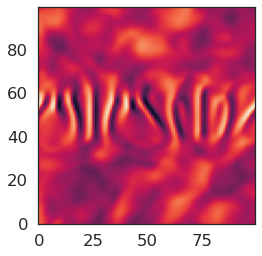

In [51]:


def X_new(nx,nt):
    x = jnp.linspace(0.098, 100.53, nx)
    t = jnp.linspace(0, 100, nt)    
    t_grid, x_grid = jnp.meshgrid(t, x, indexing="ij")
    Xnn = jnp.concatenate([(t_grid/t.max()).reshape(-1, 1), (x_grid/x.max()).reshape(-1, 1)], axis=1)

    return Xnn

nx = 100
nt = 100
uu = model.apply(new_variables, X_new(nx,nt), mutable=list(state.keys()))[0]
plt.imshow(uu[0][:,0].reshape(nt,nx),origin='lower')

In [52]:
t[114]

45.6

In [53]:
jnp.linspace(0, 100, nt)[45]

DeviceArray(45.454548, dtype=float32)

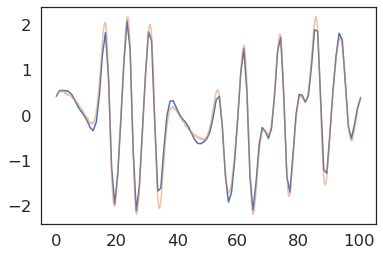

In [54]:
plt.plot(jnp.linspace(0.098, 100.53, 100),(uu[0][:,0].reshape(nt,nx)[45,:])*scale_from_outputs[0])
plt.plot(x,u[:,114],alpha=0.5)

In [55]:
np.save(path +'/scale_from_outputs',scale_from_outputs[0])

In [56]:

np.save(path +'/theta_FIN',theta)
np.save(path +'/dt_FIN',dt)


In [57]:
import pickle

In [58]:
a_file = open(path + "/new_params.pkl", "wb")
pickle.dump(new_params.unfreeze(), a_file)
a_file.close()